In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Lets imagine a dataset with 2 features, and 2 data points

# Not normalizing mean to 0 for now, otherwise we just can have two different covariant vectors, ie
# (sqrt(2), -sqrt(2)), and (-sqrt(2), sqrt(2))

class ToyData(object):
    def __init__(self):
        pass

toy = ToyData()
toy.m = 2
toy.n = 2

In [56]:
toy.rand = np.random.mtrand.RandomState(132)
toy.X = toy.rand.randn(toy.n, toy.m)

In [57]:
print('toy.X', toy.X)

toy.X [[-0.54790151  1.29491463]
 [ 0.49433234  0.5767346 ]]


In [58]:
toy.rand = np.random.mtrand.RandomState(122)
toy.y = toy.rand.randint(0, 2, size=(toy.n,))
print('y', toy.y)

y [1 0]


In [59]:
print('variate lengths', np.linalg.norm(toy.X, axis=0))

variate lengths [0.73794344 1.41754248]


In [60]:
toy.X /= np.linalg.norm(toy.X, axis=0)

In [61]:
print('variate lengths', np.sqrt(np.sum(toy.X * toy.X, 0)))

variate lengths [1. 1.]


In [62]:
print('toy.X', toy.X)

toy.X [[-0.74247087  0.91349264]
 [ 0.66987835  0.40685525]]


In [63]:
toy.residual = toy.y
toy.cos_theta = toy.X.T.dot(toy.residual)
toy.angle = np.arccos(toy.cos_theta)  #  * 180 / 3.1416
toy.angle = np.degrees(toy.angle)
print('cos_theta', toy.cos_theta)
print('angle', toy.angle)

cos_theta [-0.74247087  0.91349264]
angle [137.94232364  24.00743904]


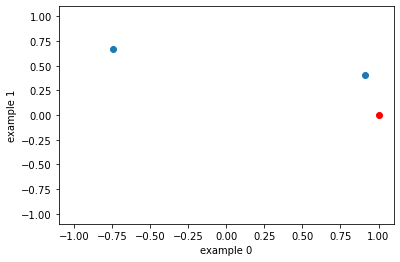

In [64]:
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.scatter(toy.X[0], toy.X[1])
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

angle [137.94232364  24.00743904]
angle [ 42.05767636 155.99256096]


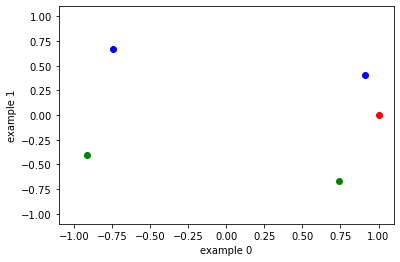

In [70]:
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.scatter(toy.X[0], toy.X[1], color='blue')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.scatter(-toy.X[0], -toy.X[1], color='green')
print('angle', toy.angle)
print('angle', 180 - toy.angle)

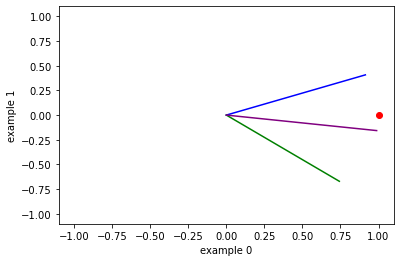

In [71]:
toy.walk0 = toy.X[:, 1]
toy.walk1 = toy.X[:, 1] - toy.X[:, 0]
# normalize length to 1:
toy.walk1 /= np.sqrt(np.sum(toy.walk1 * toy.walk1))

plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.plot((0, toy.walk0[0]), (0, toy.walk0[1]), color='blue')
plt.plot((0, - toy.X[0, 0]), (0, -toy.X[1, 0]), color='green')
plt.plot((0, toy.walk1[0]), (0, toy.walk1[1]), color='purple')
# plt.scatter(-toy.X[0], -toy.X[1], color='green')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

In [72]:
toy.sa = np.zeros((2, 2), dtype=np.float32)
toy.sa[:, 0] = toy.walk0
toy.sa[:, 1] = toy.walk1

In [74]:
toy.sb = toy.y
toy.sx = np.linalg.solve(toy.sa, toy.sb)

print(toy.sx)

[0.28776921 0.74636522]


In [76]:
print(toy.sx[0] * toy.walk0 + toy.sx[1] * toy.walk1)

[1.00000003e+00 1.30687267e-09]


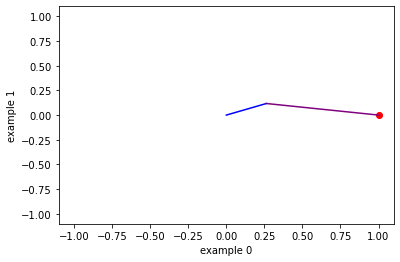

In [77]:
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')

toy.p0 = np.zeros((2,))
toy.p1 = toy.p0 + toy.sx[0] * toy.walk0
toy.p2 = toy.p1 + toy.sx[1] * toy.walk1

plt.plot((toy.p0[0], toy.p1[0]), (toy.p0[1], toy.p1[1]), color='blue')
plt.plot((toy.p1[0], toy.p2[0]), (toy.p1[1], toy.p2[1]), color='purple')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()